# การวิเคราะห์เอกสารวิจัยเกี่ยวกับ COVID-19

ในความท้าทายนี้ เราจะดำเนินการต่อในหัวข้อการระบาดของ COVID และมุ่งเน้นไปที่การประมวลผลเอกสารวิจัยทางวิทยาศาสตร์ในหัวข้อนี้ มี [ชุดข้อมูล CORD-19](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) ซึ่งมีเอกสารเกี่ยวกับ COVID มากกว่า 7,000 ฉบับ (ณ เวลาที่เขียน) พร้อมด้วยข้อมูลเมตาและบทคัดย่อ (และสำหรับประมาณครึ่งหนึ่งของเอกสารเหล่านี้ยังมีข้อความฉบับเต็มให้ด้วย)

ตัวอย่างเต็มของการวิเคราะห์ชุดข้อมูลนี้โดยใช้ [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) ซึ่งเป็นบริการวิเคราะห์ข้อความเชิงปัญญาอธิบายไว้ [ในบล็อกโพสต์นี้](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) เราจะพูดถึงเวอร์ชันที่ง่ายขึ้นของการวิเคราะห์นี้


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## การดึงข้อมูล

ก่อนอื่น เราจำเป็นต้องดึงข้อมูลเมตาดาต้าของเอกสาร CORD ที่เราจะใช้งาน

**NOTE**: เราไม่ได้ให้สำเนาชุดข้อมูลเป็นส่วนหนึ่งของคลังนี้ คุณอาจต้องดาวน์โหลดไฟล์ [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) จาก [ชุดข้อมูลนี้บน Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) ก่อน อาจต้องลงทะเบียนกับ Kaggle นอกจากนี้ คุณยังสามารถดาวน์โหลดชุดข้อมูลได้โดยไม่ต้องลงทะเบียน [จากที่นี่](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html) แต่จะรวมถึงข้อความทั้งหมดพร้อมกับไฟล์เมตาดาต้าด้วย

เราจะพยายามดึงข้อมูลโดยตรงจากแหล่งออนไลน์ อย่างไรก็ตาม หากไม่สำเร็จ คุณจำเป็นต้องดาวน์โหลดข้อมูลตามที่อธิบายไว้ข้างต้น นอกจากนี้ การดาวน์โหลดข้อมูลยังมีประโยชน์หากคุณวางแผนที่จะทดลองเพิ่มเติม เพื่อลดเวลารอ

> **NOTE** ชุดข้อมูลมีขนาดค่อนข้างใหญ่ ประมาณ 1 Gb และโค้ดบรรทัดต่อไปนี้อาจใช้เวลานานในการดำเนินการเสร็จ (~5 นาที)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

เราจะทำการแปลงคอลัมน์วันที่เผยแพร่เป็น `datetime` และสร้างฮิสโตแกรมเพื่อดูช่วงของวันที่เผยแพร่


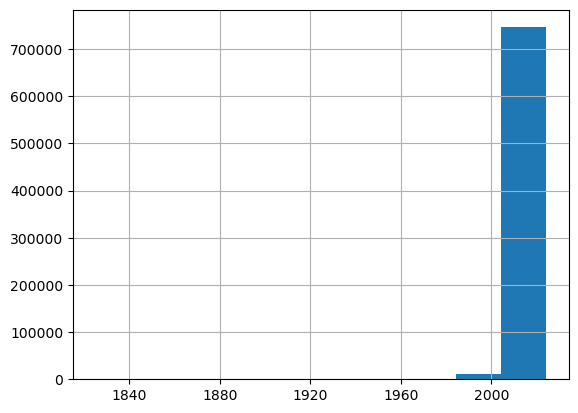

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## การดึงข้อมูลที่มีโครงสร้าง

มาดูกันว่าเราสามารถดึงข้อมูลประเภทใดจากบทคัดย่อได้บ้าง สิ่งหนึ่งที่เราอาจสนใจคือการดูว่ามีกลยุทธ์การรักษาแบบใดบ้าง และพวกมันมีการพัฒนาอย่างไรเมื่อเวลาผ่านไป ในขั้นต้น เราสามารถรวบรวมรายการยาที่เป็นไปได้สำหรับการรักษา COVID ด้วยตนเอง รวมถึงรายการการวินิจฉัย จากนั้นเราจะตรวจสอบรายการเหล่านั้นและค้นหาคำที่เกี่ยวข้องในบทคัดย่อของงานวิจัย


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


เราได้เพิ่มคอลัมน์หลายคอลัมน์ใน dataframe ของเราที่แสดงจำนวนครั้งที่ยาที่กำหนดหรือการวินิจฉัยปรากฏในบทคัดย่อ

> **หมายเหตุ** เราเพิ่มช่องว่างที่จุดเริ่มต้นของคำเมื่อค้นหาช่วงข้อความย่อย หากเราไม่ทำเช่นนั้น อาจได้ผลลัพธ์ที่ผิดพลาด เพราะ *chloroquine* อาจถูกพบในช่วงข้อความย่อย *hydroxychloroquine* นอกจากนี้ เรายังบังคับให้คอลัมน์บทคัดย่อแปลงเป็น `str` เพื่อหลีกเลี่ยงข้อผิดพลาด - ลองลบ `str` แล้วดูว่าจะเกิดอะไรขึ้น

เพื่อให้ง่ายต่อการทำงานกับข้อมูล เราสามารถดึง sub-frame ที่มีเฉพาะจำนวนการนับยา และคำนวณจำนวนการปรากฏสะสม สิ่งนี้ช่วยให้เราทราบยาที่ได้รับความนิยมมากที่สุด:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

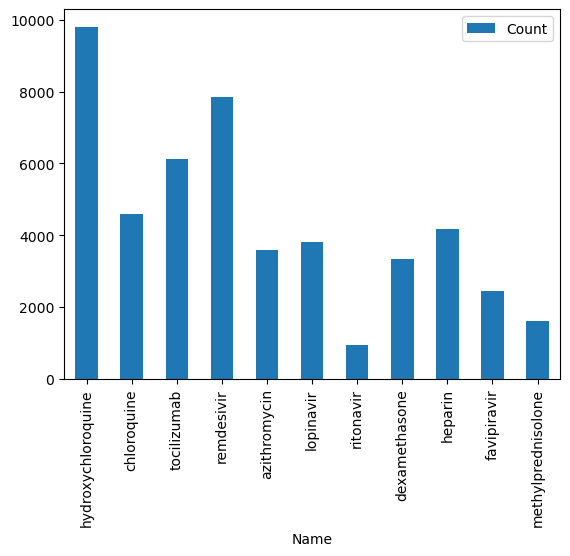

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## การมองหากระแสในกลยุทธ์การรักษา

ในตัวอย่างข้างต้น เราได้ใช้ `sum` รวมค่าทั้งหมด แต่เรายังสามารถทำแบบเดียวกันในรายเดือน:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

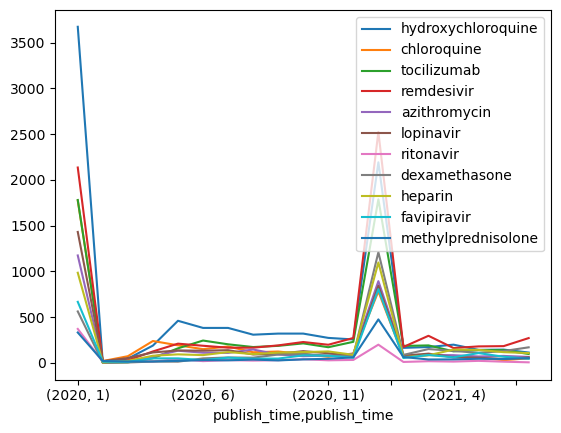

In [152]:
dfmt.plot()
plt.show()

ข้อสังเกตที่น่าสนใจก็คือ เราพบการเพิ่มขึ้นอย่างมากในสองช่วงเวลา: มกราคม 2020 และมกราคม 2021 สาเหตุเกิดจากข้อเท็จจริงที่ว่าเอกสารบางฉบับไม่ได้ระบุวันที่เผยแพร่อย่างชัดเจน และจึงถูกกำหนดให้เป็นเดือนมกราคมของปีนั้น ๆ

เพื่อให้ข้อมูลดูเข้าใจง่ายขึ้น เรามาลองแสดงผลเฉพาะยาบางตัว และเราจะ "ลบ" ข้อมูลของเดือนมกราคมออก แล้วแทนที่ด้วยค่ากลางบางค่า เพื่อให้กราฟดูสวยงามขึ้น:


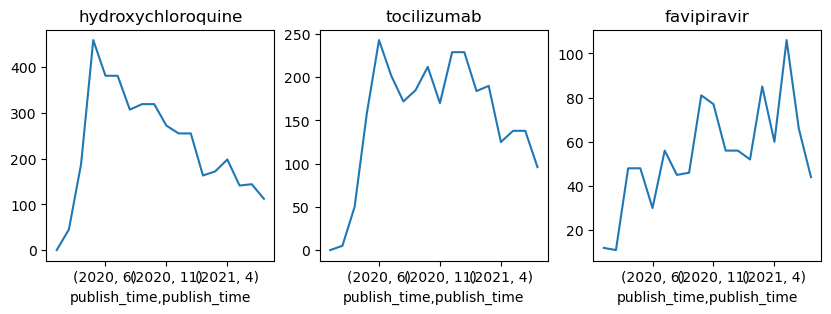

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

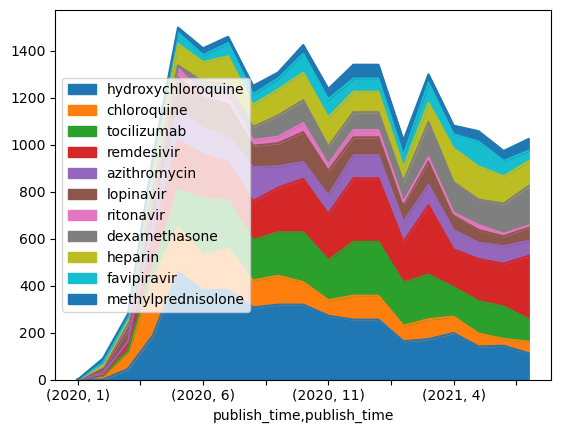

In [154]:
dfmt.plot.area()
plt.show()

ยิ่งไปกว่านั้น เราสามารถคำนวณความนิยมสัมพัทธ์เป็นเปอร์เซ็นต์:


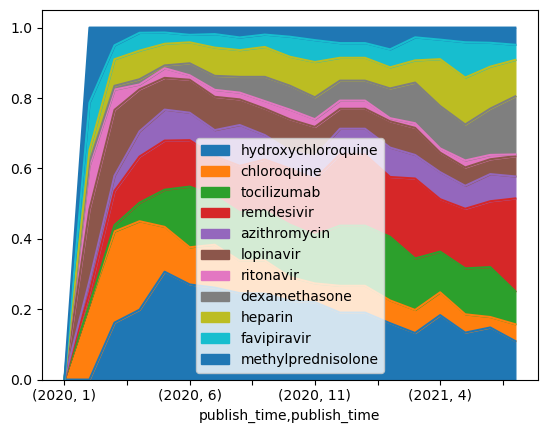

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## การคำนวณความสัมพันธ์ระหว่างยาและการวินิจฉัยโรค

หนึ่งในความสัมพันธ์ที่น่าสนใจที่สุดที่เราสามารถค้นหาได้คือวิธีที่การวินิจฉัยโรคต่าง ๆ ถูกรักษาด้วยยาต่าง ๆ เพื่อให้สามารถมองเห็นความสัมพันธ์นี้ได้ เราจำเป็นต้องคำนวณ **แผนที่ความถี่การเกิดร่วม** ซึ่งจะแสดงจำนวนครั้งที่คำสองคำถูกกล่าวถึงในเอกสารเดียวกัน

แผนที่ดังกล่าวโดยพื้นฐานแล้วคือเมทริกซ์ 2 มิติ ซึ่งแสดงผลได้ดีที่สุดด้วย **numpy array** เราจะคำนวณแผนที่นี้โดยการตรวจสอบบทคัดย่อทั้งหมด และทำเครื่องหมายเอนทิตีที่ปรากฏในนั้น:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

หนึ่งในวิธีการมองเห็นเมทริกซ์นี้คือการวาด **heatmap**:


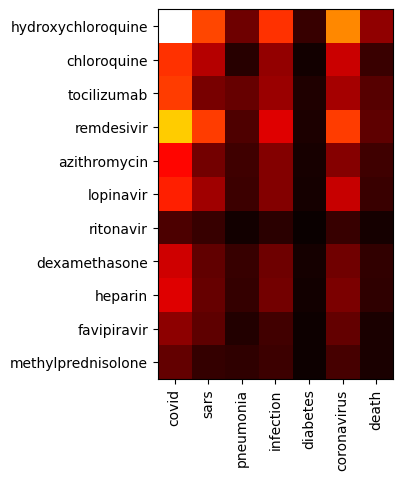

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

อย่างไรก็ตาม การแสดงผลที่ดียิ่งขึ้นสามารถทำได้โดยใช้ไดอะแกรมที่เรียกว่า **Sankey**! `matplotlib` ไม่มีฟังก์ชันในตัวสำหรับไดอะแกรมประเภทนี้ ดังนั้นเราจำเป็นต้องใช้ [Plotly](https://plotly.com/python/) ตามที่อธิบายไว้ [ในบทแนะนำนี้](https://plotly.com/python/sankey-diagram/) 

ในการสร้างไดอะแกรม Sankey ด้วย Plotly เราจำเป็นต้องสร้างรายการดังต่อไปนี้:
* รายการ `all_nodes` ซึ่งประกอบด้วยโหนดทั้งหมดในกราฟ โดยจะรวมทั้งยาที่ใช้รักษาและการวินิจฉัย
* รายการของดัชนีต้นทางและปลายทาง - รายการเหล่านี้จะแสดงว่าโหนดใดอยู่ทางซ้าย และโหนดใดอยู่ทางขวาของไดอะแกรม
* รายการของลิงก์ทั้งหมด โดยแต่ละลิงก์ประกอบด้วย:
   - ดัชนีต้นทางในอาร์เรย์ `all_nodes`
   - ดัชนีปลายทาง
   - ค่าที่แสดงถึงความแข็งแกร่งของลิงก์ ซึ่งก็คือค่าจากเมทริกซ์การเกิดร่วมของเรา
   - สีของลิงก์ (ถ้ามี) เราจะเพิ่มตัวเลือกเพื่อไฮไลต์บางคำเพื่อความชัดเจน

โค้ดทั่วไปสำหรับการวาดไดอะแกรม Sankey ถูกจัดโครงสร้างไว้ในฟังก์ชัน `sankey` แยกต่างหาก ซึ่งรับสองรายการ (หมวดหมู่ต้นทางและปลายทาง) และเมทริกซ์การเกิดร่วม นอกจากนี้ยังอนุญาตให้เรากำหนดค่า threshold และละเว้นลิงก์ทั้งหมดที่อ่อนกว่าค่า threshold นั้น - ซึ่งช่วยทำให้ไดอะแกรมดูซับซ้อนน้อยลง


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## บทสรุป

คุณได้เห็นแล้วว่าเราสามารถใช้วิธีการที่ค่อนข้างง่ายในการดึงข้อมูลจากแหล่งข้อมูลที่ไม่มีโครงสร้าง เช่น ข้อความ ในตัวอย่างนี้ เราได้ใช้รายการยาที่มีอยู่แล้ว แต่จะทรงพลังมากขึ้นหากเราใช้เทคนิคการประมวลผลภาษาธรรมชาติ (NLP) เพื่อทำการดึงข้อมูลจากข้อความ ใน [บล็อกโพสต์นี้](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) เราได้อธิบายวิธีการใช้บริการคลาวด์สำหรับการดึงข้อมูล อีกทางเลือกหนึ่งคือการใช้ไลบรารี NLP ของ Python เช่น [NLTK](https://www.nltk.org/) ซึ่งวิธีการดึงข้อมูลจากข้อความโดยใช้ NLTK ได้ถูกอธิบายไว้ [ที่นี่](https://www.nltk.org/book/ch07.html)


## ความท้าทาย

ศึกษาข้อมูลเอกสารเกี่ยวกับ COVID ต่อไปในแนวทางดังนี้:

1. สร้างเมทริกซ์การเกิดร่วมของยาต่าง ๆ และดูว่ายาใดมักจะปรากฏร่วมกัน (เช่น ถูกกล่าวถึงในบทคัดย่อเดียวกัน) คุณสามารถปรับแต่งโค้ดสำหรับการสร้างเมทริกซ์การเกิดร่วมของยาและการวินิจฉัยได้
1. แสดงภาพเมทริกซ์นี้โดยใช้ heatmap
1. หากต้องการความท้าทายเพิ่มเติม คุณอาจลองแสดงภาพการเกิดร่วมของยาด้วย [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram) [ไลบรารีนี้](https://pypi.org/project/chord/) อาจช่วยคุณวาด chord diagram ได้
1. อีกหนึ่งความท้าทายเพิ่มเติม ลองดึงข้อมูลปริมาณการใช้ยาต่าง ๆ (เช่น **400mg** ใน *รับประทาน chloroquine 400mg ต่อวัน*) โดยใช้ regular expressions และสร้าง dataframe ที่แสดงปริมาณการใช้ยาต่าง ๆ สำหรับยาแต่ละชนิด **หมายเหตุ**: พิจารณาค่าตัวเลขที่อยู่ใกล้กับชื่อยานั้นในข้อความ



---

**ข้อจำกัดความรับผิดชอบ**:  
เอกสารนี้ได้รับการแปลโดยใช้บริการแปลภาษา AI [Co-op Translator](https://github.com/Azure/co-op-translator) แม้ว่าเราจะพยายามให้การแปลมีความถูกต้อง แต่โปรดทราบว่าการแปลอัตโนมัติอาจมีข้อผิดพลาดหรือความไม่แม่นยำ เอกสารต้นฉบับในภาษาต้นทางควรถือเป็นแหล่งข้อมูลที่เชื่อถือได้ สำหรับข้อมูลที่สำคัญ ขอแนะนำให้ใช้บริการแปลภาษามนุษย์มืออาชีพ เราจะไม่รับผิดชอบต่อความเข้าใจผิดหรือการตีความที่ผิดพลาดซึ่งเกิดจากการใช้การแปลนี้
